###  LSTD – Least-squares temporal difference.

Implement least-squares temporal difference and apply it to one of the
environments you have already implemented. What are your feature
vectors? Use an iterative solver (from a linear-algebra software library)
for the linear system 𝐴−1̂
𝑡 w𝑡 = b̂
𝑡
. Explore what happens when you
update the weight vector w𝑡 periodically and not in every time step.
Finally, compare the performance to at least one other algorithm you
have already implemented.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import choice, random, randint
from tqdm import tqdm_notebook as tqdm

In [2]:
class GridCliff:
    
    def __init__(self, h, w):
        self.w = w
        self.h = h
        
        self.actions = [0, 1, 2, 3] #up, down, left, right
        
        self.start = w-1
        self.goal = 0
        
        self.terminal = [self.goal]
        self.states = [s for s in range(w, h*w)] + [self.start, self.goal]
        self.cliff = [s for s in range(self.goal+1, self.start)]
        
        self.num_states = h*w
        self.num_actions = len(self.actions)
        
        #### state numbering ####
        # 0  #  #  #  #  5 
        # 6  7  8  9  10 11
        # 12 13 14 15 16 17
        # 18 19 20 21 22 23
        
        # 0 is the final state
        #### state numbering ####
        
    def state_coordinates(self, s):
        return (s // self.w, s % self.w)
        
    def step(self, s, a):
        assert s in (self.states + [self.start, self.goal]), f'{s=} not valid.'
        
        if s in self.terminal:
            return s, 0
        
        action_values = [-self.w, +self.w, -1, +1]
        sprime = s + action_values[a]
        
        if sprime in self.cliff:
            return self.start, -100
        elif (s // self.w) != (sprime // self.w) and a > 1: # out horizontally
            return s, -1
        elif sprime not in self.states: # out vertically
            return s, -1
        else:
            return sprime, -1
        
def get_GT(grid):
    w = grid.w
    h = grid.h
    
    v = np.zeros((h, w))
    v_states = np.zeros(h*w)
    
    for x in range(w):
        for y in range(h):
            v[y, x] = x + y
            v_states[y*w + x] = x + y
    for x in range(w):
        v[0, x] = np.nan
        v_states[x] = np.nan
            
    v[0, 0] = 0
    v_states[0] = 0
    v[0, w-1] = w+1
    v_states[w-1] = w+1
            
    return -v, -v_states

In [3]:
def features(s, grid):
    t_coords = grid.state_coordinates(grid.terminal[0])
    s_coords = grid.state_coordinates(s)
    
    dist = np.sqrt(((np.array(t_coords) - np.array(s_coords))**2).sum())
    x = s_coords# + (dist,)
    
    return np.array(x)

def LSTD(grid, feature, π, γ=0.99, ϵ=0.01, episodes=1000, max_steps=1000):
    dim = len(feature(0, grid))
    
    A_inv = np.eye(dim)/ϵ
    b = np.zeros(dim)
    w = A_inv @ b
    mse_list = []
    
    for ep in tqdm(range(episodes)):
        S = choice(grid.states)
        x = feature(S, grid)
        
        for step in range(max_steps):
            A = np.random.choice(grid.actions, p=π[S])
            S_prime, R = grid.step(S, A)

            x_prime = feature(S_prime, grid)

            v = A_inv.transpose() @ (x - γ*x_prime)
            A_inv = A_inv - np.outer((A_inv @ x), v) / (1 + v.dot(x))
            b = b + R*x
            w = A_inv @ b
            
            if S_prime in grid.terminal:
                break
            else:
                S, x = S_prime, x_prime
        else:
            print('could not find s prime')
            
        # mse for evaluation
        v_pred = np.zeros(grid.num_states)
        for s in grid.states:
            v_pred[s] = w @ feature(s, grid)
        mse_list.append(compute_mse(v_pred, grid))
                
    return w, mse_list

def LSTD_stepwise(grid, feature, π, γ=0.99, ϵ=0.01, step_size=100, episodes=1000, max_steps=1000):
    dim = len(feature(0, grid))
    
    A_inv = np.eye(dim)/ϵ
    b = np.zeros(dim)
    w = A_inv @ b
    mse_list = []
    
    counter = 0
    
    for ep in tqdm(range(episodes)):
        S = choice(grid.states)
        x = feature(S, grid)
        
        for step in range(max_steps):
            counter += 1
            A = np.random.choice(grid.actions, p=π[S])
            S_prime, R = grid.step(S, A)

            x_prime = feature(S_prime, grid)

            v = A_inv.transpose() @ (x - γ*x_prime)
            A_inv = A_inv - np.outer((A_inv @ x), v) / (1 + v.dot(x))
            b = b + R*x
            
            if S_prime in grid.terminal:
                break
            else:
                S, x = S_prime, x_prime
                
        if counter % step_size == 0:
            w = A_inv @ b
            
        # mse for evaluation
        v_pred = np.zeros(grid.num_states)
        for s in grid.states:
            v_pred[s] = w @ feature(s, grid)
        mse_list.append(compute_mse(v_pred, grid))
            
                
    return w, mse_list

def TD_prediction(grid, π, γ=0.99, α=0.01, episodes=1000, max_steps=1000):
    V = np.random.random(grid.num_states)
    for s in grid.terminal:
        V[s] = 0.0
    
    for ep in tqdm(range(episodes)):
        S = choice(grid.states)

        for step in range(max_steps):
            A = np.random.choice(grid.actions, p=π[S])
            S_prime, R = grid.step(S, A)
            
            V[S] = V[S] + α*(R + γ*V[S_prime] - V[S])
            
            if S_prime in grid.terminal:
                break
            else:
                S = S_prime
                
    return V

In [4]:
def compute_mse(v, grid):
    v_gt = get_GT(grid)[1]
    
    # ignore cliff states
    sum_of_squared_diffs = 0
    for s in grid.states:
        sum_of_squared_diffs += (v[s] - v_gt[s])**2
    
    return sum_of_squared_diffs.mean()

In [5]:
h, w = 4, 6

g = GridCliff(h, w)

print(get_GT(g)[0])

[[-0. nan nan nan nan -7.]
 [-1. -2. -3. -4. -5. -6.]
 [-2. -3. -4. -5. -6. -7.]
 [-3. -4. -5. -6. -7. -8.]]


In [6]:
π_GT = np.zeros((g.num_states, g.num_actions), dtype=np.double)

π_GT[:] = (1,0,0,0)
π_GT[w-1] = (0,1,0,0)
for x in range(w):
    if x == 0:
        π_GT[w + x] = (1,0,0,0)
    else:
        π_GT[w + x] = (0,0,1,0)

In [7]:
# π = np.random.random((g.num_states, g.num_actions))
# π = π/π.sum(axis=1, keepdims=True)
π = π_GT

w_pred_step, mse_list_step = LSTD_stepwise(g, features, π, γ=1.0, ϵ=0.01, episodes=500)
w_pred, mse_list = LSTD(g, features, π, γ=1.0, ϵ=0.01, episodes=500)
v_pred_td = TD_prediction(g, π, γ=1.0, α=0.01, episodes=500)

v_pred = np.zeros(g.num_states)
v_pred_step = np.zeros(g.num_states)

for s in g.states:
    v_pred[s] = w_pred @ features(s, g)
    v_pred_step[s] = w_pred_step @ features(s, g)

/tmp/ipykernel_104/2850063505.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_104/2850063505.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_104/2850063505.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

[[ 0.   nan  nan  nan  nan -5.6]
 [-0.9 -2.  -3.2 -4.3 -5.4 -6.5]
 [-1.8 -2.9 -4.1 -5.2 -6.3 -7.4]
 [-2.7 -3.8 -4.9 -6.1 -7.2 -8.3]]
mse = 3.08


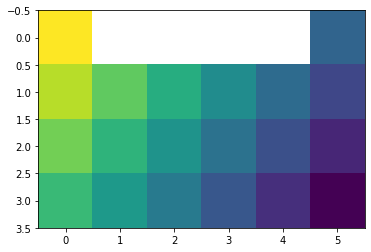

In [8]:
#v_pred.round(decimals=3)
v_pred_coord = np.zeros((h, w))

for s in (g.states + g.cliff):
    y, x = g.state_coordinates(s)
    
    if s in g.cliff:
        v_pred_coord[y, x] = np.nan
    else:
        v_pred_coord[y, x] = v_pred[s]
        
print(v_pred_coord.round(decimals=1))
plt.imshow(v_pred_coord)
print(f'mse = {compute_mse(v_pred, g):.3}')

[[ 0.   nan  nan  nan  nan -5.3]
 [-0.9 -2.  -3.1 -4.2 -5.2 -6.3]
 [-1.9 -3.  -4.  -5.1 -6.2 -7.2]
 [-2.8 -3.9 -5.  -6.  -7.1 -8.2]]
mse = 3.09


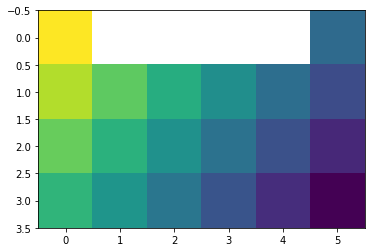

In [9]:
# v_pred_step.round(decimals=3)
v_pred_coord_step = np.zeros((h, w))

for s in (g.states + g.cliff):
    y, x = g.state_coordinates(s)
    
    if s in g.cliff:
        v_pred_coord_step[y, x] = np.nan
    else:
        v_pred_coord_step[y, x] = v_pred_step[s]
print(v_pred_coord_step.round(decimals=1))
plt.imshow(v_pred_coord_step)
print(f'mse = {compute_mse(v_pred_step, g):.3}')

TD learning looks worse here but contrary to the other two methods it actually converges towards the true value function after a while.

[[ 0.   nan  nan  nan  nan  0.2]
 [-1.  -1.9 -2.4 -2.3 -1.9 -1.1]
 [-0.5 -0.7 -1.  -0.2 -0.5 -0.5]
 [-0.1 -0.1 -0.   0.4  0.5  0.2]]
mse = 4.13e+02


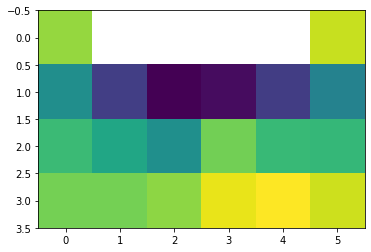

In [10]:
# v_pred_td.round(decimals=3)
v_pred_coord_td = np.zeros((h, w))

for s in (g.states + g.cliff):
    y, x = g.state_coordinates(s)
    
    if s in g.cliff:
        v_pred_coord_td[y, x] = np.nan
    else:
        v_pred_coord_td[y, x] = v_pred_td[s]
print(v_pred_coord_td.round(decimals=1))
plt.imshow(v_pred_coord_td)
print(f'mse = {compute_mse(v_pred_td, g):.3}')

The step wise version has a lower variance

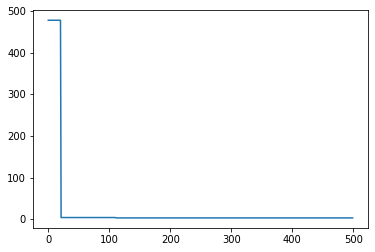

In [11]:
plt.plot(mse_list_step)

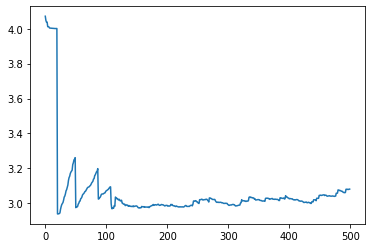

In [12]:
plt.plot(mse_list)

In the following experiment the cliff is removed. This results in an easier problem with a linear value function (=> the value function can be learned exactly). Notice the fast convergence. This demonstrates the importance of using the right type of features.

In [103]:
h, w = 4, 6

g = GridCliff(h, w)
g.states = [n for n in range(h*w)]
g.cliff = []
g.start = w*h - 1

print(get_GT(g))

[[-0. nan nan nan nan -7.]
 [-1. -2. -3. -4. -5. -6.]
 [-2. -3. -4. -5. -6. -7.]
 [-3. -4. -5. -6. -7. -8.]]


In [104]:
π_GT = np.zeros((g.num_states, g.num_actions), dtype=np.double)

for s in g.states:
    y, x = g.state_coordinates(s)
    if x == 0:
        π_GT[s] = (1, 0, 0, 0)
    else:
        π_GT[s] = (0, 0, 1, 0)

In [110]:
# π = np.random.random((g.num_states, g.num_actions))
# π = π/π.sum(axis=1, keepdims=True)
π = π_GT

w_pred_step = LSTD_stepwise(g, features, π, γ=1.0, ϵ=0.01, episodes=100)
w_pred = LSTD(g, features, π, γ=1.0, ϵ=0.01, episodes=100)
v_pred_td = TD_prediction(g, π, γ=1.0, α=0.01, episodes=100)

v_pred = -100*np.ones(g.num_states)
v_pred_step = -100*np.ones(g.num_states)

for s in g.states:
    v_pred[s] = w_pred @ features(s, g)
    v_pred_step[s] = w_pred_step @ features(s, g)

/tmp/ipykernel_204/1733203627.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_204/1733203627.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_204/1733203627.py:81: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [111]:
#v_pred.round(decimals=3)
v_pred_coord = np.zeros((h, w))

for s in g.states:
    y, x = g.state_coordinates(s)
    v_pred_coord[y, x] = v_pred[s]
print(v_pred_coord.round(decimals=1))

[[ 0. -1. -2. -3. -4. -5.]
 [-1. -2. -3. -4. -5. -6.]
 [-2. -3. -4. -5. -6. -7.]
 [-3. -4. -5. -6. -7. -8.]]


In [112]:
# v_pred_step.round(decimals=3)
v_pred_coord_step = np.zeros((h, w))

for s in g.states:
    y, x = g.state_coordinates(s)
    v_pred_coord_step[y, x] = v_pred_step[s]
print(v_pred_coord_step.round(decimals=1))

[[ 0. -1. -2. -3. -4. -5.]
 [-1. -2. -3. -4. -5. -6.]
 [-2. -3. -4. -5. -6. -7.]
 [-3. -4. -5. -6. -7. -8.]]


In [113]:
# v_pred_td.round(decimals=3)
v_pred_coord_td = np.zeros((h, w))

for s in g.states:
    y, x = g.state_coordinates(s)
    v_pred_coord_td[y, x] = v_pred_td[s]
print(v_pred_coord_td.round(decimals=1))

[[ 0.   0.4  0.1  0.3  0.5  0.7]
 [-0.2  0.7  0.4  0.4  0.4  0.2]
 [-0.3 -0.1 -0.   0.1  0.2  0.8]
 [-0.3  0.4  0.7  0.6  0.5  0.5]]
